In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
import copy
import calc_vector
import multiprocessing as mp
import random
import tensorflow as tf

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse.linalg import spsolve

pd.set_option('display.max_columns', 100)

In [2]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Read Data

Files in DropBox for easy sharing Work and Personal laptop

In [123]:
path = '/Users/Robin/Dropbox/Data/'

## Amazon Fashion

In [124]:
#Full data
# file_name = 'amazon_clothing_shoes_jewelry_data' 

#2m user above 5 ratings
# file_name = 'amazon_2m'

#0.63m user above 5 ratings
file_name = 'amazon_063m' 

## MovieLens

In [125]:
# Full data
# file_name = '25m_ml'

# 2m subset
# file_name = '2m-ml'
# With 3.0 as rating threshold for a 1
# file_name = '2m-ml_3_r_thres'
# ml_07m subset
# file_name = 'ml_07'

In [126]:
path = 'Data/'
df = pd.read_pickle(path + file_name)
df.head()

,user,item,rating,verified
0,A2OLY7TMIYHOQQ,B00EAKJUUW,5.0,True
1,A3F6ZP5VM8QUC6,B00D98EGE6,5.0,True
2,A21PFJA2O7Z5GY,B01DTEXSHA,2.0,True
3,AV9HIUYXBZODJ,B0045DBUBQ,3.0,True
4,A73X3PFCRTJVX,B00DEWBMU8,5.0,True


# Data Prep
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [127]:
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes

In [128]:
df.item_id.unique().max()

115062

## Leave item out train test split

In [78]:
def leave_x_out(full_data, leave_out):
    # Input: data must be formatted by func: tranfsorm
    # Output: full_data = without all entries in leave one out set
    #         leave_one_out_set = data with one user and one item from full_data
    
    full_data['index'] = full_data.index
    user_items_ind = full_data.groupby('user_id')['index'].apply(list)
    index_to_drop = []
    
    for indices in user_items_ind:
        if len(indices) > leave_out:
            for to_leave_out in range(leave_out):
                index = indices[- to_leave_out]
                index_to_drop.append(index)
    
    leave_one_out_set = full_data.loc[index_to_drop]
    full_data_leave_one_out = full_data.drop(index_to_drop)
    
    return full_data_leave_one_out.drop(columns=['index']), leave_one_out_set.drop(columns=['index'])

In [79]:
def create_matrices(data, n_users, n_items):
        r = data['new_user_id']
        c = data['new_item_id']
        d = data['rating']
        m = sparse.csr_matrix((d, (r, c)), shape=(n_users, n_items))
        m_ones = m.copy()
        m_ones[m_ones > 0] = 1
                               
        return m, m_ones

In [80]:
train_set, test_set = leave_x_out(df, 2)
val_set, test_set = leave_x_out(test_set, 1)

In [81]:
print('Leave one item out per user',
      '\n\nFull Df length:\t\t', len(df),
      '\nTraining Set length:\t', len(train_set),
      '\nTesting Set length:\t', len(test_set),
      '\nValidation Set length:\t', len(val_set))

Leave one item out per user 

Full Df length:		 70745 
Training Set length:	 54343 
Testing Set length:	 8201 
Validation Set length:	 8201


# Model: BPR MF in TF

- Paper: https://arxiv.org/pdf/1205.2618.pdf
- Code:  https://github.com/valerystrizh/bpr/blob/master/BPR.java

---
## Init: Variables

In [82]:
total_users = len(df.user_id.unique())
total_items = len(df.item_id.unique())
latent_dim = 20
learning_rate = 0.05

n_epochs = 10

user_items = train_set.groupby('user_id')['item_id'].apply(list)
train_users = train_set.user_id.unique()
train_items = train_set.item_id.unique()

In [83]:
print('Total Users:', total_users,
      '\nTotal Items:', total_items)

Total Users: 34844 
Total Items: 7545


---
## Define Model, Loss, Train Step and Helpers

In [84]:
class BPR_MF(tf.keras.Model):
    def __init__(self, init_func, total_users, total_items, latent_dim): #b_init_func
        super(BPR_MF, self).__init__()
        self.p = tf.Variable(init_func(total_users, latent_dim), name="p")
        self.q = tf.Variable(init_func(total_items, latent_dim), name="q")
#         self.b = tf.Variable(b_init_func((total_items, 1)), name="b")
    
    def call(self, uij):
        return tf.math.multiply(self.p[uij[0]], (self.q[uij[1]] - self.q[uij[2]]))

In [85]:
class Loss:
    def __call__(self, x):
        return - tf.math.log_sigmoid(tf.math.reduce_sum(x))

In [86]:
@tf.function
def train_step(model, optimizer, uij):
    with tf.GradientTape(persistent=True) as tape:
        x = model(uij) 
        loss = loss_obj(x) # -x or not? 

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

In [102]:
def draw_sample(train_users, train_items, user_items):
    u = int(np.random.choice(train_users))
    u_items = user_items[u]
    i = random.choice(u_items)
    j = int(np.random.choice(train_items)) # neg item

    while j in u_items: # j cannot be the same item or an item with a 1
        j = int(np.random.choice(train_items))
        
    return tf.Variable([u, i, j])

In [119]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

---
# Train Model

## Init Model and Loss

In [103]:
normal_init = lambda v, d: tf.random.normal((v, d), 0.0, 1.0/d)
zero_init = lambda v: tf.zeros(v,1)

model = BPR_MF(normal_init, total_users, total_items, latent_dim)

In [104]:
loss_obj = Loss()
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

---
## Train Loop

In [106]:
train_time_s = time.time()
total_losses = []
for epoch in range(n_epochs):
    ep_time_s = time.time()
    ep_losses = []
    for sample in range(len(train_set)):
        uij_sample = draw_sample(train_users, train_items, user_items)
        loss = train_step_manual(model, optimizer, uij_sample)
        
        ep_losses.append(loss)
    ep_loss = np.average(ep_losses)
    
    print('Epoch:', epoch.numpy(), '\tLoss:', round(ep_loss,4), '\tEpoch Time:', time.time() - ep_time_s)
    total_losses.append(ep_loss)

print('Total training time:', time.time() - train_time_s)

KeyboardInterrupt: 

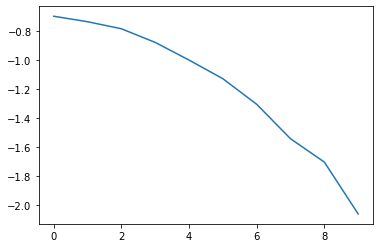

In [52]:
plt.plot(total_losses)
plt.show()

In [ ]:
model.q[1001]

In [108]:
model = BPR_MF(normal_init, total_users, total_items, latent_dim)

In [110]:
model.q.numpy()
model.p.numpy()

array([[ 0.01688648,  0.0505784 , -0.02644658, ..., -0.01099488,
         0.01813504, -0.07018466],
       [ 0.02288403, -0.02241064,  0.06765871, ...,  0.02549377,
        -0.00330726,  0.05510823],
       [ 0.02313883,  0.0388522 ,  0.11835849, ..., -0.02955933,
         0.07207369, -0.01683548],
       ...,
       [ 0.03210168,  0.03930054, -0.05666804, ...,  0.04753113,
         0.01625811,  0.04558265],
       [-0.02696693,  0.06174047,  0.00139138, ..., -0.02127414,
        -0.02689567,  0.01205104],
       [-0.00726422, -0.0592706 ,  0.03855373, ...,  0.00179589,
         0.02941306,  0.09110733]], dtype=float32)

In [ ]:
@tf.function
def train(opt, u, i, j):
    with tf.GradientTape(persistent=True) as tape:
        pu = p_full[u]
        qi = q_full[i]
        qj = q_full[j]
        x = tf.math.multiply(pu, (qi - qj))
        loss = loss_obj(x)
    opt.minimize(loss_obj, )
    gradients = [tape.gradient(loss, pu), tape.gradient(loss, qi), tape.gradient(loss, qj)]    
#     gradients = tape.gradient(x, [pu, qi, qj])
    print(gradients[0])
    grads_and_vars = zip(gradients, [pu, qi, qj])
#     opt.apply_gradients(grads_and_vars)
    return gradients

In [ ]:
grads = train(opt, u, i, j)

In [ ]:
grads[0]

In [ ]:
grads[1]

In [ ]:
grads[2]

In [ ]:
qi - qj

In [ ]:
dx_dqj

In [ ]:
dx_dpu

In [ ]:
q_full[i] - q_full[j]

In [ ]:
@tf.function
def add(a, b):
    c = tf.math.add(a, b)
    for i in tf.range(10):
        c = tf.math.add(a, c)
        tf.print(tf.math.add(a,c))


a = tf.Variable([1,2,3])
b = tf.Variable([3,2,1])

In [ ]:
@tf.function
def f(x,y):
    result = tf.constant(10.0)
    for i in tf.range(y):
        result = tf.math.multiply(x, y)
    return result

In [ ]:
def grad(x, y):
    with tf.GradientTape() as t:
        t.watch(x)
        out = f(x,y)
    return t.gradient(out, tf.dtypes.cast(y, tf.float32))

In [ ]:
x = tf.convert_to_tensor(2.0)
y = tf.convert_to_tensor(3.0)

In [ ]:
print(grad(x, y))

In [ ]:
x = tf.ones((2,2))

with tf.GradientTape() as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z = tf.multiply(y, y)

# Use the tape to compute the derivative of z with respect to the
# intermediate value y.
dz_dy = t.gradient(z, y)
print(dz_dy)
print(dz_dy.numpy())

In [ ]:
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as t:
  t.watch(x)
  y = x * x
  z = y * y
dz_dx = t.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
dy_dx = t.gradient(y, x)  # 6.0
del t  # Drop the reference to the tape

In [ ]:
dz_dx

In [ ]:
x

In [ ]:
add(a, b)

In [ ]:
class BPR_MF(tf.keras.Model):
    def __init__(self, init_func, b_init_func, total_users, total_items, latent_dim):
        super(BPR_MF, self).__init__()
        self.p = tf.Variable(init_func(total_users, latent_dim), name="p")
        self.q = tf.Variable(init_func(total_items, latent_dim), name="q")
        self.b = tf.Variable(b_init_func((total_items, 1)))
    
    def call(self, u, i, j):
        return self.b[i] - self.b[j] + tf.matmul(self.p[u], (self.q[i] - self.q[j]), transpose_b=True)

In [ ]:
normal_init = lambda v, d: tf.random.normal((v, d), 0.0, 1.0/d)
zero_init = lambda v: tf.zeros(v,1)
model = BPR_MF(init_func = normal_init,
               b_init_func = zero_init,
               total_users = total_users,
               total_items = total_items,
               latent_dim = latent_dim)

In [ ]:
class Loss:
#     def __init__(self):
        
    def __call__(self, x):
        return tf.math.log_sigmoid(-x)

In [ ]:
loss_obj = Loss()

In [ ]:
def make_train_step():
    optimizer = tf.keras.optimizers.Adam(lr=0.1)
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    
    @tf.function
    def train_step(scope_model):
        with tf.GradientTape() as tape:
            xhat = scope_model(u=1, i=1, j=2)
            loss = tf.reduce_sum(loss_obj(xhat))
        gradients = tape.gratients(loss, scope_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, scope_model.trainable_variables))
        train_loss(loss)

    return train_loss, train_step

In [ ]:
results = []
n_iters = 500 + 1
print_every = 50
for i in range(n_iters): 
    train_step(model)
    res = train_loss.result()  
    results.append(res)

    if i % print_every == 0:
        print('help')

# Appendix

In [ ]:
# df = pd.read_pickle('Data/amazon_clothing_shoes_jewelry_data')
# users = df.user.unique()
# to_keep = users[:300000]

# user_indices = df.groupby('user')['index'].apply(list)
# to_keep_indices = []
# for u in user_indices[to_keep]:
#     to_keep_indices.extend(u)

# new_df = df_og.loc[to_keep_indices]
# len(to_keep_indices)

# Begin ordered tf BPR_MF model

In [ ]:
class BPR_MF():    
    def __init__(self, total_users, total_items, latent_dim):
        self.total_users = total_users
        self.total_items = total_items
        self.latent_dim = latent_dim
        self.p = tf.random.normal(shape=(total_users, latent_dim), mean=0.0, stddev=0.1)
        self.q = tf.random.normal(shape=(total_items, latent_dim), mean=0.0, stddev=0.1)
        self.b = tf.zeros(shape=(total_items, 1))
        self.train_users = None
        self.train_items = None
        self.user_items = None

    def get_train_batch(self, user):
        item_list_user = self.user_items[user]
        i = np.random.choice(item_list_user)
        j = np.random.choice(self.train_items)
        while j in item_list_user: # j cannot be an item liked by user
            j = np.random.choice(self.train_items)
            
        return [int(user), int(i), int(j)]
        
    def update(self, x):
        
    
    def train(self, u, i, j):
        x = self.b[i] - self.b[j] + tf.math.reduce_sum(tf.math.multiply(self.p[u], (self.q[i] - self.q[j])))
        loss = - tf.math.log(tf.math.sigmoid(x))
        self.update(x)
        
        return loss
    
    def fit(self, train_data, epochs):
        self.train_users = train_data.user_id.unique()
        self.train_items = train_data.item_id.unique()
        self.user_items = train_data.groupby('user_id')['item_id'].apply(list)
        for epoch in range(epochs):
            epoch_losses = []
            for pos_examples in range(len(train_data)): # number of positive examples
                uij = self.get_train_batch(np.random.choice(self.train_users))
                epoch_losses.append(self.train(*uij))
            
            epoch_loss = np.average(epoch_losses)
            print('Epoch:', epoch, 'Loss:', epoch_loss)


## standard SVD model

In [ ]:
class SVD:
    """" All functions used to run, test, plot and store the
    Singular Value Decomposition Model"""

    def __init__(self, params, total_users, total_items):
        self.nolf = params['nolf']
        self.n_epochs = params['n_epochs']
        self.alpha = params['alpha']
        self.alpha_b = params['alpha_b']
        self.alpha_cb = params['alpha_cb']
        self.use_bias = params['use_bias']
        self.use_impl_fb = params['use_impl_fb']
        self.use_color = params['use_color']
        self.use_weight_ver = params['use_weight_ver']
        self.bu_reg = params['bu_reg']
        self.bi_reg = params['bi_reg']
        self.pu_reg = params['pu_reg']
        self.qi_reg = params['qi_reg']
        self.x_reg = params['x_reg']
        self.cb_reg = params['cb_reg']
        self.ver_weight = params['ver_weight']
        self.stop = params['stop']
        self.random_state = params['random_state']
        self.total_users = total_users
        self.total_items = total_items
        self.params = params
        self.mu = 0 
        self.N = []
        self.N_test = []
        self.t = pd.DataFrame()
        self.c = pd.DataFrame()
        self.F = pd.DataFrame()

        self.train_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.val_data = pd.DataFrame()
        self.train_time = 0
        self.best_model = {}
        self.model = {}
        self.test_results = {}

    def fit(self, train_data, val_data=[], verbose=1, plot=True, plot_name=''):
        self.train_data = train_data
        self.val_data = val_data
        self.SVD(train_data=train_data, val_data=val_data, verbose=verbose, plot=plot, plot_name=plot_name)
        return self

    
###############################################################################################
    
    def SVD(self, train_data, val_data, verbose, plot, plot_name):
        """"The SVD algorithm with sgd
        input: rating dataset with columns:['rating', 'user_id', 'item_id']
        output: the resulting p, q, bi, bu matrices"""
        self.mu = self.create_mu(train_data)
        train_matrix = self.create_matrix(train_data, self.total_users, self.total_items)
        
        tuples_train = [tuple(x) for x in train_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        
        p = np.random.normal(0, .1, (total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (total_items, self.nolf))  # items
        
        # user and item biases
        b_user = np.zeros(total_users)
        b_item = np.zeros(total_items)
        
        # using color (pareto split (0,1,2)) attribute bias
        if self.use_color:
            print('Creating F and c, for incorporating color bias')
            self.F, self.c = self.init_color(train_data)

        # implicit fb rated, not rated
        x = np.random.normal(0, .1, (total_items, self.nolf))
        impl_fb_u = np.zeros(self.nolf)
        if self.use_impl_fb:
            print('Creating N, for incorporating implicit feedback')
            self.N = train_data.groupby('new_user_id')['new_item_id'].apply(list)
        
        # 0.5 weight on the errors of verified = False user item combinations
        if self.use_weight_ver:
            i_verified = train_data.set_index(['new_user_id', 'new_item_id'])['verified']
            i_verified = i_verified.loc[~i_verified.index.duplicated(keep='first')]
        
        sqrt_Nu = 0
        cb = 0
        rmses = []
        val_rmses = []
        smallest_val_rmse = 10000
        val_rmse = "na"
        start = time.time()
        for epoch in range(self.n_epochs):
            total_sq_error = 0
            for u, i, r_ui in tuples_train:
                u = int(u)
                i = int(i)
                
                if self.use_impl_fb:
                    impl_fb_u = np.zeros(self.nolf)
                    sqrt_Nu = np.sqrt(len(self.N[u]))
                    for j in self.N[u]:
                        impl_fb_u += x[j] / sqrt_Nu

                if self.use_color and epoch > 5:
                    F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                    u_mu = self.mu + b_user[u]
                    sqrt_F_ui = np.sqrt(len(F_ui))
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        cb += (r_uf - u_mu) * self.c[u,i][index]
                    cb /=  sqrt_F_ui
                        
                if self.use_bias:   
                    error = r_ui - ((self.mu + b_user[u] + b_item[i] + cb) + np.dot(p[u] + impl_fb_u, q[i]))
                    if self.use_weight_ver and not i_verified[u,i]:
                        error = self.ver_weight * error
                    
                    b_user[u] += self.alpha_b * (error - self.bu_reg * b_user[u])
                    b_item[i] += self.alpha_b * (error - self.bi_reg * b_item[i])
                else:
                    error = r_ui - np.dot(p[u], q[i])

                p[u] += self.alpha * (error * q[i] - self.pu_reg * p[u])
                q[i] += self.alpha * (error * (p[u] + impl_fb_u) - self.qi_reg * q[i])
                total_sq_error += np.square(error)
            
                if self.use_impl_fb:
                    for j in self.N[u]:
                        x[j] += self.alpha * (error * q[i] / sqrt_Nu - self.x_reg * x[j])
                
                if self.use_color and epoch > 5:
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        u_mu = self.mu + b_user[u]
                        self.c[u,i][index] += self.alpha_cb * (error * (1/sqrt_F_ui) * (r_uf - u_mu) - self.cb_reg * self.c[u,i][index])
                
            rmse = np.sqrt(total_sq_error / len(tuples_train))
            rmses.append(rmse)
            
            self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
            
            # Validation
            if len(val_data) > 0:
                new_val_rmse = self.test(val_data, val=True)
                val_rmses.append(new_val_rmse)
                if new_val_rmse < smallest_val_rmse:
                    smallest_val_rmse = new_val_rmse
                    self.best_model = copy.deepcopy(self.model)
                val_rmse = new_val_rmse
                
            # Epoch Printing
            if epoch % verbose == 0:
                if len(val_data) > 0:
                    print('Epoch:', epoch, '  RMSE:', rmse, ' Val_RMSE:', val_rmse)
                else:
                    print('Epoch:', epoch, '  RMSE:', rmse)
            
            if self.stop and val_rmses[-2:][0] < val_rmse:
                print('BREAK: Validation set not improving anymore')
                break
                
        if plot:
            self.plot_rmse(rmses, val_rmses, plot_name)

        self.train_time = time.time() - start
        self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
#################################################################################################

    def init_color(self, data_set):
        self.t = data_set.groupby(['new_user_id', 'par_col2'])['new_item_id'].apply(list)
        F = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items)
        c = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items, random=True)
        return F, c

    def sim_items(self, x, random=False):
        u_id = x.name[0]
        col = x.iloc[0]
        if random:
            return np.random.normal(0,.1,len(self.t[u_id, col]))
        return self.t[u_id, col]
    
    def create_matrix(self, X_train, n_users, n_items):
        r = X_train['new_user_id']
        c = X_train['new_item_id']
        d = X_train['rating']
        train_matrix = sparse.coo_matrix((d, (r, c)), shape=(n_users, n_items))
    
        return train_matrix.tocsr()
    
    def create_mu(self, train_set):
        # Better mean calculation according to https://sifter.org/~simon/journal/20061211.html
        va = train_set.groupby('new_user_id')['rating'].mean().var() #variance mean ratings users
        vb = train_set.groupby('new_item_id')['rating'].mean().var() #variance mean ratings items
        k = va/vb #variance proportion
        better_mu = (train_set['rating'].mean() + train_set['rating'].sum()) / (k+len(train_set))
        return better_mu
    
    def plot_rmse(self, rmse, val_rmses=[], plot_name=''):
        plt.plot(np.arange(len(rmse)), rmse)
        if len(val_rmses) > 0:
            plt.plot(np.arange(len(val_rmses)), val_rmses, color='red')
        plt.title('RMSE')
        plt.xlabel('epoch')
        plt.ylabel('RMSE')
        plt.legend(['Train', 'Validation'])
        if len(plot_name) > 0:
            plt.savefig('Plots/' + plot_name + '.png')
        plt.show()

    def test(self, test_data, val=False):
        if not val:
            self.test_data = test_data
        tuples_test = [tuple(x) for x in test_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        test_matrix = self.create_matrix(test_data, self.total_users, self.total_items)
        
        if self.use_impl_fb and val:
            self.N_test = self.val_data.groupby('new_user_id')['new_item_id'].apply(list)
        elif self.use_impl_fb:
            self.N_test = self.test_data.groupby('new_user_id')['new_item_id'].apply(list)
            
        total_error = 0
        estimates = []
        for u, i, r_ui in tuples_test:
            u = int(u)
            i = int(i)
            est = self.estimate(u, i, test_matrix, test_data)
            estimates.append(est)
            total_error += np.square(r_ui - est)
        
        rmse = np.sqrt(total_error / len(tuples_test))
        
        if not val:
            self.test_results = {'rmse': rmse, 'estimates':estimates}
            print('RMSE on test set:', self.test_results['rmse'])
        else:
            return rmse

    def estimate(self, u, i, test_matrix, test_data):
        est = self.mu + self.model['bu'][u] + self.model['bi'][i]
        impl_fb_u = np.zeros(self.nolf)
        cb = 0
        if u in self.train_data['new_user_id'] and i in self.train_data['new_item_id']:
            
            if self.use_impl_fb and u in self.N.index:
                sqrt_Nu = np.sqrt(len(self.N[u]))
                for j in self.N[u]:   
                    impl_fb_u += self.model['x'][j] / sqrt_Nu
            
            if self.use_color and (u,i) in self.model['cbu']:
                F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                u_mu = self.mu + self.model['bu'][u]
                sqrt_F_ui = np.sqrt(len(F_ui))
                for index, f in enumerate(F_ui):
                    r_uf = self.train_data[(self.train_data['new_user_id']==u) & (self.train_data['new_item_id']==f)]['rating'].iloc[0]
                    cb += (r_uf - u_mu) * self.model['cbu'][u,i][index]
                cb /=  sqrt_F_ui
                
            est += cb + np.dot(self.model['p'][u] + impl_fb_u, self.model['q'][i])

        return est
    
    def store_results(self, log_path, res_name, user_thres, item_thres):
        train_size = round((len(self.train_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        test_size = round((len(self.test_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        val_size = round((len(self.val_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        
        result_info = {'RMSE_test': self.test_results['rmse'], 'train_speed': round(self.train_time,2)}
        other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':train_size, 'test_size':test_size, 'val_size':val_size, 'train_rmse':self.model['rmse'], 'val_rmse':self.model['val_rmse']}
        final_log = dict(result_info, **self.params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)

In [ ]:
class BPR():
    def __init__(self, total_users, total_items, params):
        self.total_users = total_users
        self.total_items = total_items
        self.nolf = params['nolf']
        self.n_iterations = params['n_iterations']
        self.alpha = params['alpha']
        self.reg_user = params['reg_user']
        self.reg_item = params['reg_item']
        self.reg_bias = params['reg_bias']
        self.alpha_decay = self.alpha / self.n_iterations
        self.model = {'loss_list':[], 'learning_rate':[]}
        
    def fit(self, train_set, val_set, val_rank, batch_size=1000):
        #Init
        s = time.time()
        self.model['p'] = np.random.normal(0, .1, (self.total_users, self.nolf))  # users
        self.model['q'] = np.random.normal(0, .1, (self.total_items, self.nolf))  # items
        self.model['b'] = np.zeros(self.total_items)
        
#         val_prec_at = []
#         val_rec_at = []
#         val_hitcount = []
        
        # Create samples 
        n_sgd_samples = len(train_set) * self.n_iterations
        
        z = 0
        self.model['train_time'] = 0
        print('init and sampling done:', time.time() - s, 'seconds')
        for i in range(self.n_iterations):
            sgd_users, sgd_pos_items, sgd_neg_items = self.user_sampling(train_set, n_sgd_samples)
        
        while (z+1)*batch_size < n_sgd_samples:
            s_it = time.time()
            it_loss = self.train(sgd_users[z*batch_size:(z+1)*batch_size], sgd_pos_items[z*batch_size:(z+1)*batch_size], sgd_neg_items[z*batch_size:(z+1)*batch_size])
            
            if z > 0:
                self.update_alpha(it_loss)
            
            z += 1
            self.model['loss_list'].append(it_loss) 

#             rec_at, prec_at, hitcount = self.eval(val_set, val_rank)
            t_it = time.time()- s_it
            self.model['train_time'] += t_it
            print('batch:', z, ' loss:', round(it_loss,4), 'iteration time:', round(t_it/2,2))#, ' val prec@' + str(val_rank), ':', round(prec_at,5), ' val rec@' + str(val_rank), ':', round(rec_at,5), '  Hits:', hitcount)#'  alpha:', self.alpha)
    
#             val_prec_at.append(prec_at)
#             val_rec_at.append(rec_at)
#             val_hitcount.append(hitcount)
            
#         self.model['val_prec_at'] = val_prec_at
#         self.model['val_rec_at'] = val_rec_at
#         self.model['val_hitcount'] = val_hitcount
        
        
    def create_matrices(self, data):
        r = data['new_user_id']
        c = data['new_item_id']
        d = data['rating']
        m = sparse.csr_matrix((d, (r, c)), shape=(self.total_users, self.total_items))
        m_ones = m.copy()
        m_ones[m_ones > 0] = 1                 
        return m, m_ones
    
    def sigmoid(self, x):
        return 1 / (1 + math.exp(-x))
    
    def user_sampling(self, data, n_samples):
        train_ratings, train_ones = self.create_matrices(train_set)
        user_items = train_set.groupby('new_user_id')['new_item_id'].apply(list)
        train_users  = train_set.new_user_id.unique()
        train_items = train_set.new_item_id.unique()
        
        sgd_users, sgd_pos_items, sgd_neg_items = [], [], []
        for sample in range(n_samples):
            u = np.random.choice(train_users)
            i = random.choice(user_items[u])

            j = int(np.random.choice(train_items)) # neg item
#             j_v = int(train_ones[u,j]) # Value, NEEDED?

            while j in user_items[u]: # j cannot be the same item or an item with a 1
                j = int(np.random.choice(train_items))
#                 j_v = int(train_ones[u,j])
            
            sgd_users.append(u)
            sgd_pos_items.append(i)
            sgd_neg_items.append(j)
            
        return sgd_users, sgd_pos_items, sgd_neg_items
        
    def train(self, users, pos_items, neg_items):
        for u, i, j in zip(users, pos_items, neg_items):
            pos_item_pred = self.model['b'][i] + np.dot(self.model['p'][u], self.model['q'][i].T)
            neg_item_pred = self.model['b'][j] + np.dot(self.model['p'][u], self.model['q'][j].T)
            diff = pos_item_pred - neg_item_pred

            loss_value = - np.log(self.sigmoid(diff)) #NEGATIVE?
            regulariser = self.reg_user * np.dot(self.model['p'][u], self.model['p'][u]) + self.reg_item * np.dot(self.model['q'][i],self.model['q'][i]) + self.reg_item/10 * np.dot(self.model['q'][j], self.model['q'][j]) + self.reg_bias * (self.model['b'][i]**2 + self.model['b'][j]**2) 
            it_loss = loss_value + regulariser

            diff_deriv = self.sigmoid(- diff)
            
            #SGD update
            for f in range(self.nolf): # update each factor (see notes for derivatives)
                self.model['p'][u,f] += self.alpha * (diff_deriv * (self.model['q'][i,f] - self.model['q'][j,f]) - self.reg_user * self.model['p'][u,f])
                self.model['q'][i,f] += self.alpha * (diff_deriv * self.model['p'][u,f] - self.reg_item * self.model['q'][i,f])
                self.model['q'][j,f] += self.alpha * (diff_deriv * (-self.model['p'][u,f]) - self.reg_item / 10 * self.model['q'][j,f])
                self.model['b'][i] += self.alpha * (diff_deriv * self.reg_bias * self.model['b'][i])
                self.model['b'][j] += self.alpha * (- diff_deriv * (- self.reg_bias) * self.model['b'][j])

#                 it_loss += self.reg_user * self.model['p'][u,f] * self.model['p'][u,f] + self.reg_item * self.model['q'][i,f] * self.model['q'][i,f] + self.reg_item * self.model['q'][j,f] * self.model['q'][j,f]
        return it_loss
        
    def update_alpha(self, it_loss):
        last_loss = self.model['loss_list'][-1]
        if(last_loss < it_loss): #bold driver
            self.alpha = 0.5 * self.alpha
            return
        
        self.alpha = (1 - self.alpha_decay) * self.alpha
        self.model['learning_rate'].append(self.alpha)
        
    def eval(self, val_set, max_rank):
        import eval_rank
        val_ratings, val_ones = create_matrices(val_set, self.total_users, self.total_items)
        result = self.model
        users = val_set.new_user_id.unique()
        items = val_set.new_item_id.unique()

        s = time.time()
        rank_at = max_rank
        mp_splits = 4
        users_split = np.array_split(users, mp_splits)

        if __name__ == '__main__':
            pool = mp.Pool(processes = mp_splits)
            ranked = pool.map(eval_rank.eval_rank, [[result, users_split[0], items, val_ones, rank_at], 
                                                    [result, users_split[1], items, val_ones, rank_at], 
                                                    [result, users_split[2], items, val_ones, rank_at], 
                                                    [result, users_split[3], items, val_ones, rank_at]])
            pool.close()

            ranked_df = pd.DataFrame()

            for i in range(mp_splits):
                ranked_df = pd.concat([ranked_df, ranked[i]])

            t = time.time() - s
            hitcount = 0
            for u in ranked_df.index:
                hitcount += len(set(ranked_df.loc[u]['true_id']) & set(ranked_df.loc[u]['pred_items_ranked']))

            prec_at =  hitcount / (len(ranked_df) * rank_at)
            rec_at = hitcount / (len(ranked_df) * len(ranked_df.loc[0]['true_id']))
            
            return prec_at, rec_at, hitcount
#             print(t)